# DataCamp Certification Case Study

### Project Brief

You have been hired as a data scientist at Discount Motors, a used car dealership in the UK. The dealership is expanding and has hired a large number of junior salespeople. Although promising, these junior employees have difficulties pricing used cars that arrive at the dealership. Sales have declined 18% in recent months, and management would like your help designing a tool to assist these junior employees.

To start with, they would like you to work with the Toyota specialist to test your idea(s). They have collected some data from other retailers on the price that a range of Toyota cars were listed at. It is known that cars that are more than £1500 above the estimated price will not sell. The sales team wants to know whether you can make predictions within this range.

You will need to present your findings in two formats:
- You must submit a written report summarising your analysis to your manager. As a data science manager, your manager has a strong technical background and wants to understand what you have done and why. 
- You will then need to share your findings with the head of sales in a 10 minute presentation. The head of sales has no data science background but is familiar with basic data related terminology. 

The data you will use for this analysis can be accessed here: `"data/toyota.csv"`

<h2>Work plan</h2>

[1. Import data and modules](#1)

[2. Data analysis (EDA)](#2)

[3. Pre-processing data for learning](#3)

[4. Learning - Baseline models](#4)

[5. Analysis of important features](#5)

[6. Final Learning and result](#6)

<a id='1'><h2>1.Import data and modules</h2></a>

In [200]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
% matplotlib inline

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression, SGDRegressor, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import explained_variance_score as evs, mean_squared_error as mse

from catboost import CatBoostRegressor
from xgboost import XGBRegressor
import xgboost as xgb

import warnings

warnings.filterwarnings('ignore')

RAND = 8

In [2]:
dataset = pd.read_csv('data/toyota.csv')
dataset.head()

,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize
0,GT86,2016,16000,Manual,24089,Petrol,265,36.2,2.0
1,GT86,2017,15995,Manual,18615,Petrol,145,36.2,2.0
2,GT86,2015,13998,Manual,27469,Petrol,265,36.2,2.0
3,GT86,2017,18998,Manual,14736,Petrol,150,36.2,2.0
4,GT86,2017,17498,Manual,36284,Petrol,145,36.2,2.0


In [3]:
dataset.info();

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6738 entries, 0 to 6737
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   model         6738 non-null   object 
 1   year          6738 non-null   int64  
 2   price         6738 non-null   int64  
 3   transmission  6738 non-null   object 
 4   mileage       6738 non-null   int64  
 5   fuelType      6738 non-null   object 
 6   tax           6738 non-null   int64  
 7   mpg           6738 non-null   float64
 8   engineSize    6738 non-null   float64
dtypes: float64(2), int64(4), object(3)
memory usage: 473.9+ KB


<h3>The following features are represented:</h3>
<ol>
    <li><b>'model'</b> - model of car</li>
    <li><b>'year'</b> - production year</li>
    <li><b>'price'</b> - price of car</li>
    <li><b>'transmission'</b> - transmission of car</li>
    <li><b>'mileage'</b> - mileage of car</li>
    <li><b>'fuelType'</b> - fuelType of car</li>
    <li><b>'tax'</b> - car tax</li>
    <li><b>'mpg'</b> - miles per gallon</li>
    <li><b>'engineSize'</b> - engine size of car</li>

<h3>Some words about DataFrame:</h3>
<ol>
    <li>Df contains of 6738 cars with 8 features</li>
	<li>Df doesn't have na-values</li>
 

<a id='2'><h2>2. Data analysis (EDA)</h2></a>

In [4]:
# convert years to object
dataset.year = dataset.year.astype('object')

In [5]:
num_vars = dataset.select_dtypes(include=['int', 'float']).columns
cat_vars = dataset.select_dtypes(include=['object']).columns

assert len(num_vars) + len(cat_vars) == dataset.shape[1]

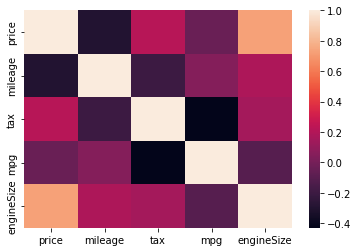

In [6]:
sns.heatmap(dataset.corr());

In [7]:
dataset.corr()

,price,mileage,tax,mpg,engineSize
price,1.000000,-0.297936,0.214498,-0.039910,0.727592
mileage,-0.297936,1.000000,-0.205285,0.044889,0.182615
tax,0.214498,-0.205285,1.000000,-0.430292,0.155727
mpg,-0.039910,0.044889,-0.430292,1.000000,-0.106868
engineSize,0.727592,0.182615,0.155727,-0.106868,1.000000


<h3>Price - the target</h3>

In [8]:
dataset.price.describe()

count     6738.000000
mean     12522.391066
std       6345.017587
min        850.000000
25%       8290.000000
50%      10795.000000
75%      14995.000000
max      59995.000000
Name: price, dtype: float64

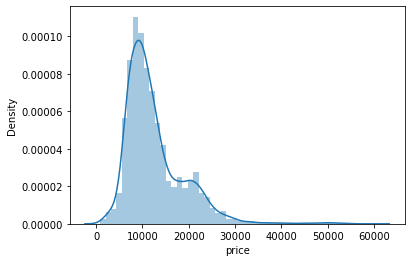

In [9]:
sns.distplot(dataset.price, kde=True);

<h4>Conclusions:<hr>
    The price distribution seems to be normal. At the same time, we see that there are cars with a high price</h4>


<h3>Model</h3>

In [10]:
dataset.model.value_counts(normalize=True).apply(lambda x: round(x, 2))

 Yaris            0.31
 Aygo             0.29
 Auris            0.11
 C-HR             0.07
 RAV4             0.07
 Corolla          0.04
 Prius            0.03
 Avensis          0.02
 Verso            0.02
 Hilux            0.01
 GT86             0.01
 Land Cruiser     0.01
 PROACE VERSO     0.00
 Supra            0.00
 Camry            0.00
 IQ               0.00
 Urban Cruiser    0.00
 Verso-S          0.00
Name: model, dtype: float64

<h4>Conclusions:<hr>
    We can see that the most popular car models are Yaris - 31%, Aygo - 29% and Auris - 11%</h4>

<h3>Year</h3>

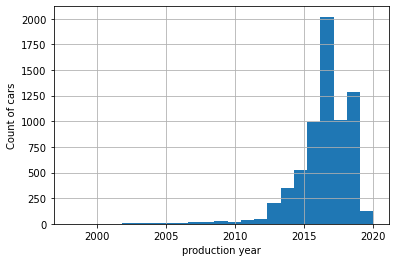

In [11]:
fig, ax = plt.subplots()
ax = dataset.year.hist(bins=dataset.year.nunique())
ax.set_ylabel('Count of cars')
ax.set_xlabel('production year');

In [12]:
dataset.year.value_counts()

2017    2019
2019    1286
2018    1015
2016     997
2015     525
2014     352
2013     204
2020     128
2012      42
2011      40
2009      29
2007      20
2008      19
2010      18
2005      12
2006      11
2004       7
2003       6
2002       4
2001       1
1999       1
2000       1
1998       1
Name: year, dtype: int64

<h4>Conclusions:<hr>
    We can see that most cars older than 2013</h4>

<h3> Transmission</h3>

In [13]:
dataset.transmission.value_counts()

Manual       3826
Automatic    2657
Semi-Auto     254
Other           1
Name: transmission, dtype: int64

In [14]:
dataset[dataset.transmission == 'Other']

,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize
2458,Yaris,2015,12795,Other,16733,Hybrid,0,78.0,1.5


<h4>Conclusions:<hr>
    Mostly represented by cars with manual and automatic transmission. Some with Semi-Auto. And also there is a unique car (Yaris of 2015) with other transmission</h4>

<h3> Mileage</h3>

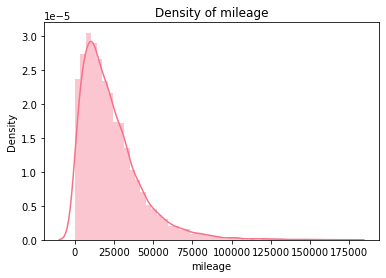

In [15]:
sns.set_palette('husl')
ax = sns.distplot(dataset.mileage)
ax.set(title='Density of mileage');

In [16]:
dataset.mileage.describe()

count      6738.000000
mean      22857.413921
std       19125.464147
min           2.000000
25%        9446.000000
50%       18513.000000
75%       31063.750000
max      174419.000000
Name: mileage, dtype: float64

In [17]:
# correlation between year and mileage
dataset.groupby('year')['mileage'].mean().sort_values()

year
2020      2118.046875
2019      5994.275272
2018     16093.459113
2000     21000.000000
2017     22086.761268
2016     28057.120361
2015     34763.360000
2014     40706.750000
2013     45820.887255
2012     53738.023810
2011     63553.275000
2010     64173.833333
2009     70039.103448
2001     76000.000000
2007     79386.200000
2002     84197.000000
2008     84719.157895
2006     86774.272727
1999     89000.000000
2005     92641.833333
2004     99889.857143
1998    100000.000000
2003    105751.666667
Name: mileage, dtype: float64

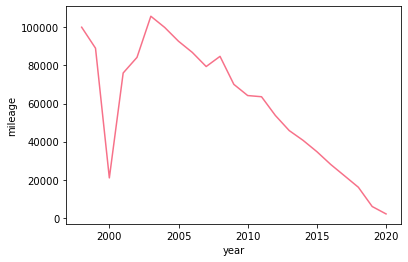

In [37]:
year_mileage = pd.DataFrame(dataset.groupby('year')['mileage'].mean())
sns.lineplot(x='year', y='mileage', data=year_mileage)
ax.set(title='Mean mileage of each year');

<h4>Conclusions:<hr>
    We can see that the mean mileage of cars is about between  20 000 and 25 000 Km<br>
    Also there is a correlation between year and mileage. The older the car, the higher its mileage</h4>

<h3> FuelType</h3>

In [39]:
dataset.fuelType.value_counts(normalize=True)

Petrol    0.606560
Hybrid    0.303206
Diesel    0.074651
Other     0.015583
Name: fuelType, dtype: float64

In [40]:
dataset.groupby('fuelType')['price'].mean()

fuelType
Diesel    15697.807157
Hybrid    17185.472834
Other     14121.161905
Petrol     9759.537803
Name: price, dtype: float64

<h4>Conclusions:<hr>
    There are 4 types of fuel. The most populat are Petrol - 60% and Hybrid - 30%<br>
    Also we see that the mean price of car with Petrol ~ 9800 and with Hybrid ~ 17000<br>
	I think that it is a good feature for our further learning</h4>

<h3> Tax</h3>

In [41]:
dataset.tax.value_counts()

145    2090
0      1790
135     678
30      587
150     529
20      253
140     223
125     196
260      93
200      74
265      41
160      41
205      28
165      23
10       23
235      21
300      16
325      13
240       5
330       4
305       2
250       1
120       1
155       1
115       1
190       1
565       1
555       1
540       1
Name: tax, dtype: int64

<h4>Conclusions:<hr>
    Most cars are taxed at $145. There are also cars with no tax</h4>

## Mpg

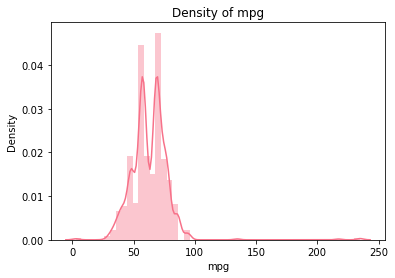

In [42]:
sns.set_palette('husl')
ax = sns.distplot(dataset.mpg)
ax.set(title='Density of mpg');

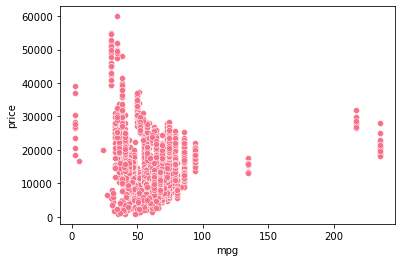

In [43]:
sns.scatterplot(x='mpg', y='price', data=dataset);

<h4>Conclusions:<hr>
   The variable "mpg" is generally distributed normally.<br>
If you look at the graph, there is no correlation with the target variable</h4>

## EngineSize

In [44]:
dataset.engineSize.value_counts()

1.0    2059
1.5    1423
1.8    1289
1.3     601
2.0     398
1.2     303
2.5     249
1.6     169
2.4      70
2.2      58
1.4      40
2.8      36
3.0      35
0.0       6
4.2       1
4.5       1
Name: engineSize, dtype: int64

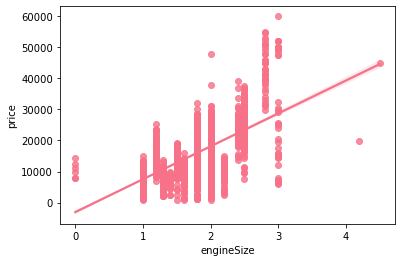

In [45]:
sns.regplot(x='engineSize', y='price', data=dataset);

<h4>Conclusions:<hr>
   Most cars with 1.0, 1.5 and 1,8 Engine size<br>
And we see on the graph that there is a correlation with the target variable - price</h4>

<a id='3'><h2>3. Pre-processing data for learning</h2></a>

In [58]:
dataset_for_train = pd.get_dummies(data=dataset, columns=cat_vars, drop_first=True)
dataset_for_train.shape

(6738, 50)

In [72]:
X_train, X_test, y_train, y_test = train_test_split(dataset_for_train.drop('price', axis=1),
                                                    dataset_for_train['price'], test_size=.2)

In [73]:
X_train.shape, X_test.shape

((5390, 49), (1348, 49))

In [75]:
y_train.mean(), y_test.mean()

(12533.551391465677, 12477.766320474777)

<a id='4'><h2>4. Learning - Baseline models</h2></a>

In [92]:
def fit_cv(model,
           X=X_train,
           y=y_train,
           cv=3, metrics=None):
    model_score = cross_val_score(model(), X, y, cv=cv)
    return model_score.mean()

In [97]:
list_models = [LinearRegression, XGBRegressor, RandomForestRegressor]
[print(i, fit_cv(i)) for i in list_models]

<class 'sklearn.linear_model._base.LinearRegression'> 0.9360822930150289
<class 'xgboost.sklearn.XGBRegressor'> 0.9548154880118652
<class 'sklearn.ensemble._forest.RandomForestRegressor'> 0.9500483741045335
<class 'sklearn.linear_model._coordinate_descent.Lasso'> 0.9358736328474372


[None, None, None, None]

<h4>Conclusions:<hr>
   The best result was got with the help of XGBoost and Random forest<br>
</h4>

<a id='5'><h2>5. Analysis of important features</h2></a>

In [104]:
dtrain = xgb.DMatrix(data=X_train, label=y_train)
dtest = xgb.DMatrix(data=X_test)

In [130]:
params = {"max_depth": 3, "eta": 1}
num_rounds = 50
xgb_model = xgb.train(params, dtrain, num_rounds)

In [198]:
preds = xgb_model.predict(dtest)
print(f'explained_variance_score:{evs(y_test, preds)}')
print(f'mean_squared_error:{mse(y_test, preds)}')

explained_variance_score:0.9440837612436404
mean_squared_error:2369531.2725409605


In [155]:
xgb_importance = {k: v for k, v in sorted(xgb_model.get_fscore().items(), key=lambda item: item[1], reverse=True)}
{k: v for k, v in xgb_importance.items() if v > 5}

{'mileage': 122,
 'mpg': 61,
 'engineSize': 32,
 'tax': 26,
 'model_ C-HR': 7,
 'year_2019': 6,
 'model_ RAV4': 6}

<h4>Conclusions:<hr>
   The inital score is 0.944. The most important features are 'mileage', mpg', 'engineSize' and 'tax'<br>
</h4>

<a id='6'><h2>6. Final Learning and result</h2></a>

In [232]:
gsc = GridSearchCV(
    estimator=xgb.XGBRegressor(),
    param_grid={"learning_rate": list(np.linspace(0, 1, 5)),
                "max_depth": [3, 5, 8]
                },
    cv=3, scoring='explained_variance', verbose=0, n_jobs=-1)

grid_result = gsc.fit(X_train, y_train)
best_params = grid_result.best_params_

In [233]:
best_params

{'learning_rate': 0.25, 'max_depth': 5}

In [234]:
grid_result.best_score_

0.9572758636664482

In [238]:
final_model = XGBRegressor(**best_params)
final_model.fit(X_train, y_train)
final_preds = final_model.predict(X_test)

In [240]:
print(f'explained_variance_score:{evs(y_test, final_preds)}')
print(f'mean_squared_error:{mse(y_test, final_preds)}')

explained_variance_score:0.960789680259155
mean_squared_error:1661303.6206933723


In [254]:
# compare the results with true-values
true_preds = pd.DataFrame()
true_preds['true'] = y_test
true_preds['preds'] = final_preds
true_preds['preds'] = true_preds['preds'].apply(lambda x: int(x))

In [256]:
true_preds.head(10)

,true,preds
995,7998,8884
3974,13495,11303
3914,9000,7779
4074,7995,8016
3535,9949,10969
6610,24250,23642
4817,7976,8226
2061,11641,11980
2216,12487,12372
3181,8500,9470
